In [39]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as skl
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [40]:
df = pd.read_csv("./Data/Regression/BivariateData/3.csv", header=None, names=['x1', 'x2', 'y'], sep=',')

df_train, df_test = skl.train_test_split(df, train_size=0.7, test_size=0.3)

df_train = torch.tensor(np.array(df_train), dtype=torch.float32)
df_test = torch.tensor(np.array(df_test), dtype=torch.float32)

In [41]:
# Hyper-parameteres
input_size = 2
hidden_sizes = np.array([60,20])
output_y = 1
num_epochs = 100
batch_size = 64
learning_rate = 0.001

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [42]:
train_loader = torch.utils.data.DataLoader(dataset=df_train,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=df_test,batch_size=batch_size,shuffle=True)

In [43]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_y):
        super(NeuralNet, self).__init__()
        
        layers = []
        
        # Adding the first hidden layer and its activation
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        
        # Adding the subsequent hidden layers and their activations
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_sizes[-1], output_y))
                
        
        
        # Combining all layers into a sequential container
        self.all_layers = nn.Sequential(*layers)
        
    def forward_propagation(self, x):
        return self.all_layers(x)

In [44]:
model = NeuralNet(input_size, hidden_sizes, output_y).to(device)

# loss and optimizer
loss_fn = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

losses = []

# Train model
total_steps = len(train_loader)

for epoch in range(num_epochs):
    # each iteration will give a batch of points 
    tot_avg_loss = 0
    
    for i,data in enumerate(train_loader): 
        points = data[:, 0:2].clone().detach().float().to(device)
        outputs = data[:,2].clone().detach().float().reshape(-1,1).to(device)
        
        # forward prop
        outputs_ = model.forward_propagation(points)
        
        loss = loss_fn(outputs_, outputs, reduction='sum')

        # backward prop and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        tot_avg_loss += loss.item()

    
    tot_avg_loss /= train_loader.dataset.shape[0] 
    losses.append(tot_avg_loss)
    
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {tot_avg_loss}')


Epoch [1/100], Loss: 2.791475614446218
Epoch [2/100], Loss: 0.43777200781664594
Epoch [3/100], Loss: 0.19522055150414047
Epoch [4/100], Loss: 0.17485240714556696
Epoch [5/100], Loss: 0.15307587682366036
Epoch [6/100], Loss: 0.12514805753691857
Epoch [7/100], Loss: 0.09559110800425212
Epoch [8/100], Loss: 0.06974372529849952
Epoch [9/100], Loss: 0.04982941975446642
Epoch [10/100], Loss: 0.035197162494606
Epoch [11/100], Loss: 0.02552981345760388
Epoch [12/100], Loss: 0.019224998409173737
Epoch [13/100], Loss: 0.014562726087596903
Epoch [14/100], Loss: 0.01164170643027757
Epoch [15/100], Loss: 0.009689882084602067
Epoch [16/100], Loss: 0.008355412047867682
Epoch [17/100], Loss: 0.007420146352603656
Epoch [18/100], Loss: 0.006800315869288618
Epoch [19/100], Loss: 0.006158918248755591
Epoch [20/100], Loss: 0.005938453949382659
Epoch [21/100], Loss: 0.005461663842535152
Epoch [22/100], Loss: 0.005178709979317769
Epoch [23/100], Loss: 0.004946915986908584
Epoch [24/100], Loss: 0.004948643252

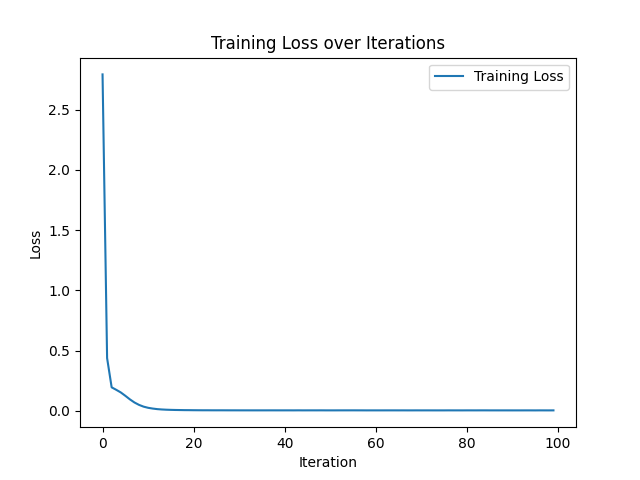

In [45]:
    
# Plotting loss
plt.figure()
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Iterations')
plt.show()
    

Average MSE Loss: 0.00010467907850397751


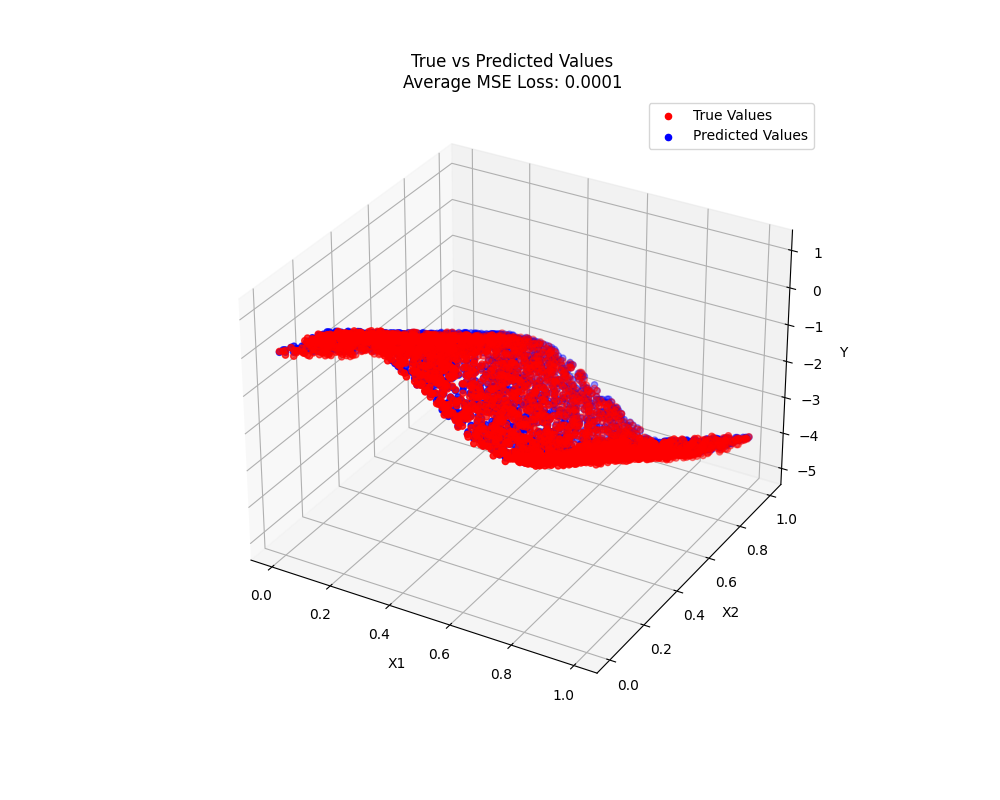

In [48]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch.nn.functional as F

# Assuming you have a trained model 'model' and a test_loader
model.eval()  # Set the model to evaluation mode
predictions = []  # To store predicted values

x1_test = []
x2_test = []
y_true = []

mse_losses = 0

# Collecting predictions and calculating MSE loss for the test set
with torch.no_grad():
    for i, data in enumerate(test_loader):
        points = data[:, 0:2].clone().detach().float().to(device)
        true_values = data[:, 2].clone().detach().float().reshape(-1,1).to(device)
        pred = model.forward_propagation(points)
        
        # print(pred, true_values)
        
        # mse_loss = F.mse_loss(pred, true_values) !! by default it gives mean of squared error
        mse_loss = loss_fn(pred, true_values, reduction='sum')
        mse_losses+=(mse_loss.item())

        predictions.extend(pred.cpu().numpy())
        x1_test.extend(points[:,0])
        x2_test.extend(points[:,1])
        y_true.extend(true_values)


x1_test = torch.Tensor(x1_test)
x2_test = torch.Tensor(x2_test)
y_true = torch.Tensor(y_true)

# Calculate average MSE loss
mse_loss /= (test_loader.dataset.shape[0])
print(f'Average MSE Loss: {mse_loss}')

# var = torch.var(test_loader.dataset[:,0:2])
# print("Variance:", var.item())


# Convert predictions to a numpy array
predictions = np.array(predictions).reshape(-1)

# Turn on interactive mode
plt.ion()

# Plot the true values and predicted values
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


# print(predictions, y_true)
# Scatter plot of true data points
ax.scatter(x1_test, x2_test, y_true, color='red', label='True Values')

# Scatter plot of predicted data points
ax.scatter(x1_test, x2_test, predictions, color='blue', label='Predicted Values')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('True vs Predicted Values\nAverage MSE Loss: {:.4f}'.format(mse_loss))
plt.legend()

# Show the plot interactively
plt.show()
